In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances as pdist
from sklearn.manifold import TSNE

from lyricpsych.data import *
from lyricpsych.utils import *
from lyricpsych.embeddings import *

# Load the lyrics data and filter out non-english entries

In [2]:
# Loading data
data = load_lyrics_db('/hdd/data/mxm_lyrics_30p/')

# compute the number of non-english words for each lyrics
res = compute_non_englishness(data)

100%|███████████████████████████████████| 24395/24395 [00:08<00:00, 2927.78it/s]


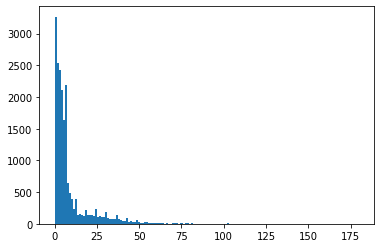

In [3]:
# distribtuion of non-english words
_ = plt.hist([r[1] for r in res if r[1] < 10000], bins=150)

## Filtering out non-english entries

In [4]:
thresh = np.percentile([r[1] for r in res if r[1] < 10000], 90)
targets = set([r[0] for r in res if r[1] < thresh])
data = [d for d in data if d[0] in targets]

# Load `word2vec` model

In [5]:
import gensim

# Load Google's pre-trained Word2Vec model.
model = (
    gensim
    .models
    .KeyedVectors
    .load_word2vec_format(
        '/hdd/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz',
        binary=True
    )
)

## Get lyrics representation using weighted sum of word vectors

In [6]:
t2v = NaiveText2Vec(model)

In [8]:
lyrics_vectors = t2v.get_vectors(data, tfidf=True)

100%|█████████████████████████████████████| 17712/17712 [03:26<00:00, 85.94it/s]


In [9]:
hexaco = load_inventory()
hexaco_vectors = t2v.get_vectors(hexaco, tfidf=True)

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 30.28it/s]


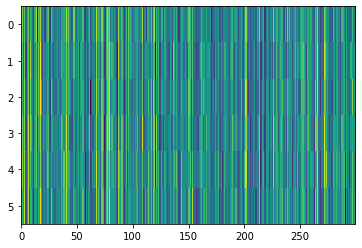

In [10]:
Y = hexaco_vectors
Y /= np.maximum(np.linalg.norm(Y, axis=1)[:, None], 1e-10)
plt.imshow(Y, aspect='auto')

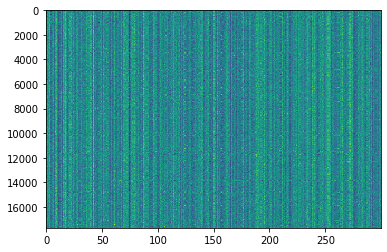

In [11]:
Z = lyrics_vectors
Z /= np.maximum(np.linalg.norm(Z, axis=1)[:, None], 1e-10)
plt.imshow(Z, aspect='auto')

In [12]:
D = pdist(Z, Y, metric='cosine')

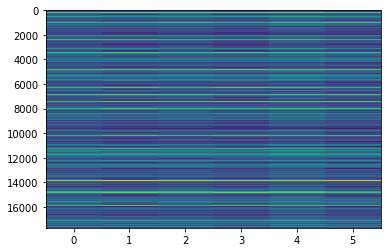

In [13]:
plt.imshow(D, aspect='auto')

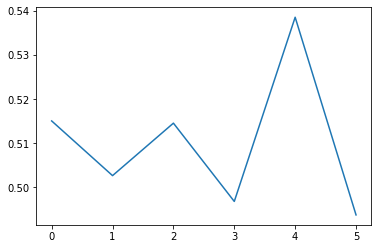

In [14]:
plt.plot(D.mean(0))

In [15]:
X = t2v.tfidf.transform([r[1] for r in data])

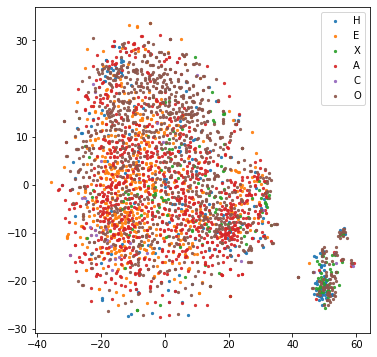

In [16]:
z_idx = np.random.choice(Z.shape[0], 3000, False)
Z_ = Z[z_idx]
# z = TSNE(2).fit_transform(D[D.sum(1) != 0])
z = TSNE(2).fit_transform(Z_)

d = D[z_idx]
d /= d.sum(1)[:, None]

plt.figure(figsize=(6, 6))
label = np.argmin(d, axis=1)
for hexaco, l in zip(['H', 'E', 'X', 'A', 'C', 'O'], range(6)):
    idx = np.where(label == l)[0]
    plt.scatter(z[idx, 0], z[idx, 1], s=5, alpha=0.9, label=hexaco)
plt.legend()

https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da